## Asynchronus Advantage Actor Critic Method

In this example we implement asynchronus advantage actor critic method to play cart pole

## Importing all relevant libraries

In [1]:
import multiprocessing
import threading
import tensorflow as tf
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt

### Defining all Hyperparameters

In [2]:
# Defining all hyper-parameters
GAME = 'CartPole-v0'
OUTPUT_GRAPH = True
LOG_DIR = './log'
N_WORKERS = multiprocessing.cpu_count()
MAX_GLOBAL_EP = 1000
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 10
GAMMA = 0.9
ENTROPY_BETA = 0.001
LR_A = 0.001 # learning rate for actor
LR_C = 0.001 # learning rate for critic
GLOBAL_RUNNING_R = []
GLOBAL_EP = 0

### Constructing the environment

In [3]:
env = gym.make(GAME)
N_S = env.observation_space.shape[0]
N_A = env.action_space.n

### Constructing the model

In [29]:
class ACNet(object) :
    
    def __init__(self,scope,globalAC=None) :
        if scope == GLOBAL_NET_SCOPE :  # get global network
            with tf.variable_scope(scope) :
                self.s = tf.placeholder(tf.float32,[None,N_S],'S')
                self.a_params, self.c_params = self._build_net(scope)[-2:]
        else : # local net, calculate losses
            with tf.variable_scope(scope) :
                self.s = tf.placeholder(tf.float32,[None,N_S],'S')
                self.a_his  = tf.placeholder(tf.int32,[None,],'A')
                self.v_target = tf.placeholder(tf.float32,[None,1],'Vtarget')
                
                self.a_prob, self.v, self.a_params, self.c_params = self._build_net(scope)
                
                td = tf.subtract(self.v_target,self.v,name='TD_error')
                with tf.name_scope('c_loss') :
                    self.c_loss = tf.reduce_mean(tf.square(td))
                    
                with tf.name_scope('a_loss') :
                    log_prob = tf.reduce_mean(tf.log(self.a_prob + 1e-5)*tf.one_hot(self.a_his,N_A,dtype=tf.float32),axis=1,keep_dims=True)
                    exp_v = log_prob*tf.stop_gradient(td)
                    entropy = -tf.reduce_sum(self.a_prob*tf.log(self.a_prob + 1e-5),axis=1,keep_dims=True) # encourage exploration
                    self.exp_v = ENTROPY_BETA*entropy + exp_v
                    self.a_loss = tf.reduce_sum(-self.exp_v)
                    
                with tf.name_scope('local_grad') :
                    self.a_grads = tf.gradients(self.a_loss,self.a_params)
                    self.c_grads = tf.gradients(self.c_loss,self.c_params)
                    
                with tf.name_scope('sync') :
                    with tf.name_scope('pull') :
                        self.pull_a_params_op = [l_p.assign(g_p) for l_p,g_p in zip(self.a_params,globalAC.a_params)]
                        self.pull_c_params_op = [l_p.assign(g_p) for l_p,g_p in zip(self.c_params,globalAC.c_params)]
                    
                    with tf.name_scope('push') :
                        self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads,globalAC.a_params))
                        self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads,globalAC.c_params))
                        
    def _build_net(self,scope) :
        w_init = tf.random_normal_initializer(0., .1)
        with tf.variable_scope('actor') :
            l_a = tf.layers.dense(self.s,200,tf.nn.relu6,kernel_initializer=w_init,name='la')
            a_prob = tf.layers.dense(l_a,N_A,tf.nn.softmax,kernel_initializer=w_init,name='ap')
            
        with tf.variable_scope('critic') :
            l_c = tf.layers.dense(self.s,100,tf.nn.relu6,kernel_initializer=w_init,name='lc')
            v = tf.layers.dense(l_c,1,kernel_initializer=w_init,name='v') # state value
        
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=scope + '/actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=scope + '/critic')
        
        return a_prob, v, a_params, c_params
    
    def update_global(self,feed_dict) :  # run by a local
        SESS.run([self.update_a_op,self.update_c_op],feed_dict)  # local grads applies to a global net
        
    def pull_global(self) :  # run by a local
        SESS.run([self.pull_a_params_op,self.pull_c_params_op])
        
    def choose_action(self,s) :  # run a local
        prob_weights = SESS.run(self.a_prob,feed_dict={self.s: s[np.newaxis,:]})
        action = np.random.choice(range(prob_weights.shape[1]),p=prob_weights.ravel())  # select action w.r.t the actions prob
        
        return action

In [30]:
class Worker(object) :
    
    def __init__(self,name,globalAC) :
        self.env = gym.make(GAME).unwrapped
        self.name = name
        self.AC = ACNet(name,globalAC)
        
    def work(self) :
        global GLOBAL_RUNNING_R, GLOBAL_EP
        total_step = 1
        buffer_s, buffer_a, buffer_r = [], [], []
        while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP :
            s = self.env.reset()
            ep_r = 0
            while True :
                
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                
                if done :
                    r = -5
                    
                ep_r += r
                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)
                
                if total_step % UPDATE_GLOBAL_ITER == 0 or done : # update global and assign to local net
                    if done :
                        v_s_ = 0 # terminal
                    else :
                        v_s_ = SESS.run(self.AC.v,{self.AC.s:s_[np.newaxis,:]})[0,0]
                        
                    buffer_v_target = []
                    for r in buffer_r[::-1] : # reverse buffer r
                        v_s_ = r + GAMMA*v_s_
                        buffer_v_target.append(v_s_)
                    buffer_v_target.reverse()
                    
                    buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.array(buffer_a), np.vstack(buffer_v_target)
                    feed_dict = {self.AC.s : buffer_s,
                                 self.AC.a_his : buffer_a,
                                 self.AC.v_target : buffer_v_target}
                    
                    self.AC.update_global(feed_dict)
                    
                    buffer_s, buffer_a, buffer_r = [], [], []
                    self.AC.pull_global()
                    
                s = s_
                total_step += 1
                if done :
                    if len(GLOBAL_RUNNING_R) == 0: # record running episode reward
                        GLOBAL_RUNNING_R.append(ep_r)
                    else :
                        GLOBAL_RUNNING_R.append(0.99*GLOBAL_RUNNING_R[-1] + 0.01*ep_r)
                        
                    print(self.name,
                          "Ep:",GLOBAL_EP,
                          "| Ep_r: %i"%GLOBAL_RUNNING_R[-1])
                    
                    GLOBAL_EP += 1
                    break

### Main Loop to run the algorithm

W_1W_0  Ep: 0 | Ep_r: 13
Ep: 0 | Ep_r: 14
W_3 Ep: 2 | Ep_r: 14
W_1 Ep: 3 | Ep_r: 14
W_2 Ep: 4 | Ep_r: 14
W_0 Ep: 5 | Ep_r: 14
W_3 Ep: 6 | Ep_r: 13
W_0 Ep: 7 | Ep_r: 13
W_1 Ep: 8 | Ep_r: 14
W_2 Ep: 9 | Ep_r: 14
W_3 Ep: 10 | Ep_r: 14
W_1 Ep: 11W_2 | Ep_r: 14
 Ep: 11 | Ep_r: 14
W_0 Ep: 13 | Ep_r: 14
W_1 Ep: 14 | Ep_r: 14
W_0 Ep: W_2 15 | Ep_r: 14
Ep: 15 | Ep_r: 14
W_3 Ep: 17 | Ep_r: 14
W_2 Ep: 18 | Ep_r: 14
W_0 Ep: 19 | Ep_r: 14
W_1 Ep: 20 | Ep_r: 14
W_0 Ep: 21 | Ep_r: 14
W_2 Ep: 22 | Ep_r: 14
W_0 Ep: 23 | Ep_r: 14
W_1 Ep: 24 | Ep_r: 14
W_2 Ep: 25 | Ep_r: 14
W_3 Ep: 26 | Ep_r: 14
W_0 Ep: 27 | Ep_r: 14
W_2 Ep: 28 | Ep_r: 15
W_0 Ep: 29 | Ep_r: 15
W_0 Ep: 30 | Ep_r: 14
W_3 Ep: 31 | Ep_r: 15
W_3 Ep: 32 | Ep_r: 15
W_2 Ep: 33 | Ep_r: 15
W_1 Ep: 34 | Ep_r: 15
W_0 Ep: 35 | Ep_r: 16
W_3 Ep: 36 | Ep_r: 16
W_2 Ep: 37 | Ep_r: 16
W_0 Ep: 38 | Ep_r: 16
W_3 Ep: 39 | Ep_r: 16
W_1 Ep: 40 | Ep_r: 17
W_0 Ep: 41 | Ep_r: 17
W_2 Ep: 42 | Ep_r: 17
W_1 Ep: 43 | Ep_r: 17
W_0 Ep: 44 | Ep_r: 17
W_3 Ep: 45 | Ep_r: 1

W_0 Ep: 354 | Ep_r: 161
W_2 Ep: 355 | Ep_r: 161
W_3 Ep: 356 | Ep_r: 161
W_1 Ep: 357 | Ep_r: 161
W_2 Ep: 358 | Ep_r: 161
W_1 Ep: 359 | Ep_r: 160
W_3 Ep: 360 | Ep_r: 161
W_0 Ep: 361 | Ep_r: 163
W_2 Ep: 362 | Ep_r: 168
W_3 Ep: 363 | Ep_r: 172
W_0 Ep: 364 | Ep_r: 176
W_2 Ep: 365 | Ep_r: 178
W_3 Ep: 366 | Ep_r: 181
W_1 Ep: 367 | Ep_r: 190
W_0 Ep: 368 | Ep_r: 193
W_3 Ep: 369 | Ep_r: 193
W_2 Ep: 370 | Ep_r: 193
W_1 Ep: 371 | Ep_r: 193
W_0 Ep: 372 | Ep_r: 193
W_2 Ep: 373 | Ep_r: 193
W_3 Ep: 374 | Ep_r: 193
W_1 Ep: 375 | Ep_r: 193
W_0 Ep: 376 | Ep_r: 192
W_3 Ep: 377 | Ep_r: 192
W_2 Ep: 378 | Ep_r: 192
W_1 Ep: 379 | Ep_r: 191
W_0 Ep: 380 | Ep_r: 191
W_3 Ep: 381 | Ep_r: 191
W_2 Ep: 382 | Ep_r: 190
W_1 Ep: 383 | Ep_r: 190
W_0 Ep: 384 | Ep_r: 190
W_2 Ep: 385 | Ep_r: 189
W_3 Ep: 386 | Ep_r: 189
W_2 Ep: 387 | Ep_r: 187
W_3 Ep: 388 | Ep_r: 186
W_2 Ep: 389 | Ep_r: 184
W_2 Ep: 390 | Ep_r: 182
W_1 Ep: 391 | Ep_r: 182
W_0 Ep: 392 | Ep_r: 182
W_3 Ep: 393 | Ep_r: 182
W_2 Ep: 394 | Ep_r: 182
W_1 Ep: 395 | Ep

W_3 Ep: 696 | Ep_r: 156
W_2 Ep: 697 | Ep_r: 156
W_1 Ep: 698 | Ep_r: 156
W_3 Ep: 699 | Ep_r: 156
W_0 Ep: 700 | Ep_r: 157
W_1 Ep: 701 | Ep_r: 157
W_2 Ep: 702 | Ep_r: 157
W_3 Ep: 703 | Ep_r: 158
W_0 Ep: 704 | Ep_r: 158
W_1 Ep: 705 | Ep_r: 158
W_0 Ep: 706 | Ep_r: 159
W_2 Ep: 707 | Ep_r: 161
W_1 Ep: 708 | Ep_r: 161
W_3 Ep: 709 | Ep_r: 164
W_0 Ep: 710 | Ep_r: 165
W_1 Ep: 711 | Ep_r: 165
W_2 Ep: 712 | Ep_r: 166
W_3 Ep: 713 | Ep_r: 166
W_2 Ep: 714 | Ep_r: 166
W_0 Ep: 715 | Ep_r: 166
W_1 Ep: 716 | Ep_r: 167
W_3 Ep: 717 | Ep_r: 167
W_0 Ep: 718 | Ep_r: 166
W_2 Ep: 719 | Ep_r: 166
W_1 Ep: 720 | Ep_r: 167
W_0 Ep: 721 | Ep_r: 166
W_3 Ep: 722 | Ep_r: 167
W_2 Ep: 723 | Ep_r: 167
W_3 Ep: 724 | Ep_r: 167
W_0 Ep: 725 | Ep_r: 168
W_2 Ep: 726 | Ep_r: 169
W_1 Ep: 727 | Ep_r: 172
W_3 Ep: 728 | Ep_r: 172
W_1 Ep: 729 | Ep_r: 173
W_3 Ep: 730 | Ep_r: 173
W_2 Ep: 731 | Ep_r: 174
W_0 Ep: 732 | Ep_r: 177
W_2 Ep: 733 | Ep_r: 176
W_3 Ep: 734 | Ep_r: 177
W_0 Ep: 735 | Ep_r: 177
W_1 Ep: 736 | Ep_r: 178
W_2 Ep: 737 | Ep

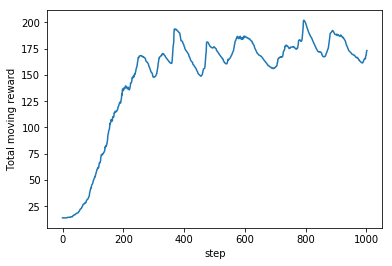

In [31]:
%matplotlib inline
tf.reset_default_graph()
SESS = tf.Session()
with tf.device("/cpu:0") :
    OPT_A = tf.train.RMSPropOptimizer(LR_A,name='RMSPropA')
    OPT_C = tf.train.RMSPropOptimizer(LR_C,name='RMSPropC')
    GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE) # we only need its params
    workers = []
    # create worker
    for i in range(N_WORKERS) :
        i_name = 'W_%i'%i  # worker name
        workers.append(Worker(i_name,GLOBAL_AC))
        
    COORD = tf.train.Coordinator()
    SESS.run(tf.global_variables_initializer())
    
    if OUTPUT_GRAPH :
        if not os.path.exists(LOG_DIR) :
            shutil.rmtree(LOG_DIR)
            
        tf.summary.FileWriter(LOG_DIR,SESS.graph)
        
    worker_threads = []
    for worker in workers :
        job = lambda: worker.work()
        t = threading.Thread(target=job)
        t.start()
        worker_threads.append(t)
        
    COORD.join(worker_threads)
    
    plt.plot(np.arange(len(GLOBAL_RUNNING_R)),GLOBAL_RUNNING_R)
    plt.xlabel('step')
    plt.ylabel('Total moving reward')
    plt.show()